In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Define the Chebyshev FLNN Model ---
class ChebyshevFLNN_PDE(nn.Module):
    def __init__(self, order_x=5, order_t=5):
        super(ChebyshevFLNN_PDE, self).__init__()

        self.order_x = order_x
        self.order_t = order_t

        # Total features = (order_x + 1) * (order_t + 1)
        # We use Tensor Product expansion to capture x*t interactions
        self.feature_dim = (self.order_x + 1) * (self.order_t + 1)

        # Single output layer (No hidden layers in FLNN)
        self.output_layer = nn.Linear(self.feature_dim, 1, bias=False)

    def compute_chebyshev_basis(self, z, order):
        # Recursive definition: T_0=1, T_1=z, T_{n+1} = 2zT_n - T_{n-1}
        T = [torch.ones_like(z), z]
        for n in range(2, order + 1):
            T_next = 2 * z * T[-1] - T[-2]
            T.append(T_next)

        # Stack shape: [batch_size, order+1]
        return torch.cat(T, dim=1)

    def forward(self, x, t):
        # 1. Expand x into Chebyshev polynomials [1, x, 2x^2-1, ...]
        Tx = self.compute_chebyshev_basis(x, self.order_x)  # Shape: [N, Ox]

        t_scaled = 2 * t - 1  # Scale t to [-1, 1]
        # 2. Expand t into Chebyshev polynomials
        Tt = self.compute_chebyshev_basis(t_scaled, self.order_t)  # Shape: [N, Ot]

        # 3. Tensor Product Expansion (Cross-terms)
        # We need every combination of Tx[i] * Tt[j] to capture interactions
        # Einstein Summation: batch(b), i, j -> batch(b), (i*j) flattened
        # This creates features like: 1, x, t, xt, (2x^2-1)t, etc.
        phi = torch.einsum('bi,bj->bij', Tx, Tt).reshape(x.size(0), -1)

        # 4. Linear Weighted Sum
        u_pred = self.output_layer(phi)
        return u_pred

# --- 2. Training Setup ---

# Hyperparameters
EPOCHS = 5500
LR = 0.001
ORDER_X = 7  # Polynomial degree for space
ORDER_T = 7  # Polynomial degree for time

# Initialize Model
model = ChebyshevFLNN_PDE(order_x=ORDER_X, order_t=ORDER_T)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Generate Collocation Points (Random points in domain)
N_points = 2000
x_phys = (torch.rand(N_points, 1) * 2 - 1).requires_grad_(True) # x in [-1, 1]
t_phys = torch.rand(N_points, 1).requires_grad_(True)           # t in [0, 1]

# --- 3. Training Loop ---
print(f"Training FLNN with Chebyshev Tensor Product (Features: {model.feature_dim})...")

loss_history = []

for epoch in range(EPOCHS+1):
    optimizer.zero_grad()

    # --- A. Physics Loss (The PDE) ---
    u = model(x_phys, t_phys)

    # Compute gradients (du/dt and d2u/dx2)
    du_dt = torch.autograd.grad(u, t_phys, torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x_phys, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_phys, torch.ones_like(u), create_graph=True)[0]

    # Residual = u_t - u_xx
    # We normalize equation terms for better convergence if needed
    pde_residual = du_dt - d2u_dx2
    loss_pde = torch.mean(pde_residual**2)

    # --- B. Initial Condition Loss (t=0) ---
    # u(x, 0) = sin(pi * x)
    x_ic = torch.rand(200, 1) * 2 - 1
    t_ic = torch.zeros(200, 1)
    u_ic_pred = model(x_ic, t_ic)
    u_ic_true = torch.sin(np.pi * x_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_true)**2)

    # --- C. Boundary Condition Loss (x=-1 and x=1) ---
    # u(-1, t) = 0 and u(1, t) = 0
    t_bc = torch.rand(200, 1)
    x_bc_left = torch.ones(200, 1) * -1
    x_bc_right = torch.ones(200, 1) * 1

    u_bc_left = model(x_bc_left, t_bc)
    u_bc_right = model(x_bc_right, t_bc)

    loss_bc = torch.mean(u_bc_left**2) + torch.mean(u_bc_right**2)

    # Total Loss
    loss = loss_pde + loss_ic + loss_bc

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.6f}")


Training FLNN with Chebyshev Tensor Product (Features: 64)...
Epoch 0: Loss 743.158081
Epoch 500: Loss 0.664899
Epoch 1000: Loss 0.157918
Epoch 1500: Loss 0.048325
Epoch 2000: Loss 0.017606
Epoch 2500: Loss 0.006236
Epoch 3000: Loss 0.003035
Epoch 3500: Loss 0.001311
Epoch 4000: Loss 0.000973
Epoch 4500: Loss 0.000235
Epoch 5000: Loss 0.000131
Epoch 5500: Loss 0.000107
Epoch 6000: Loss 0.000342
Epoch 6500: Loss 0.000109
Epoch 7000: Loss 0.000333
Epoch 7500: Loss 0.000115
Epoch 8000: Loss 0.000251
Epoch 8500: Loss 0.000107
Epoch 9000: Loss 0.000106
Epoch 9500: Loss 0.000110
Epoch 10000: Loss 0.000501


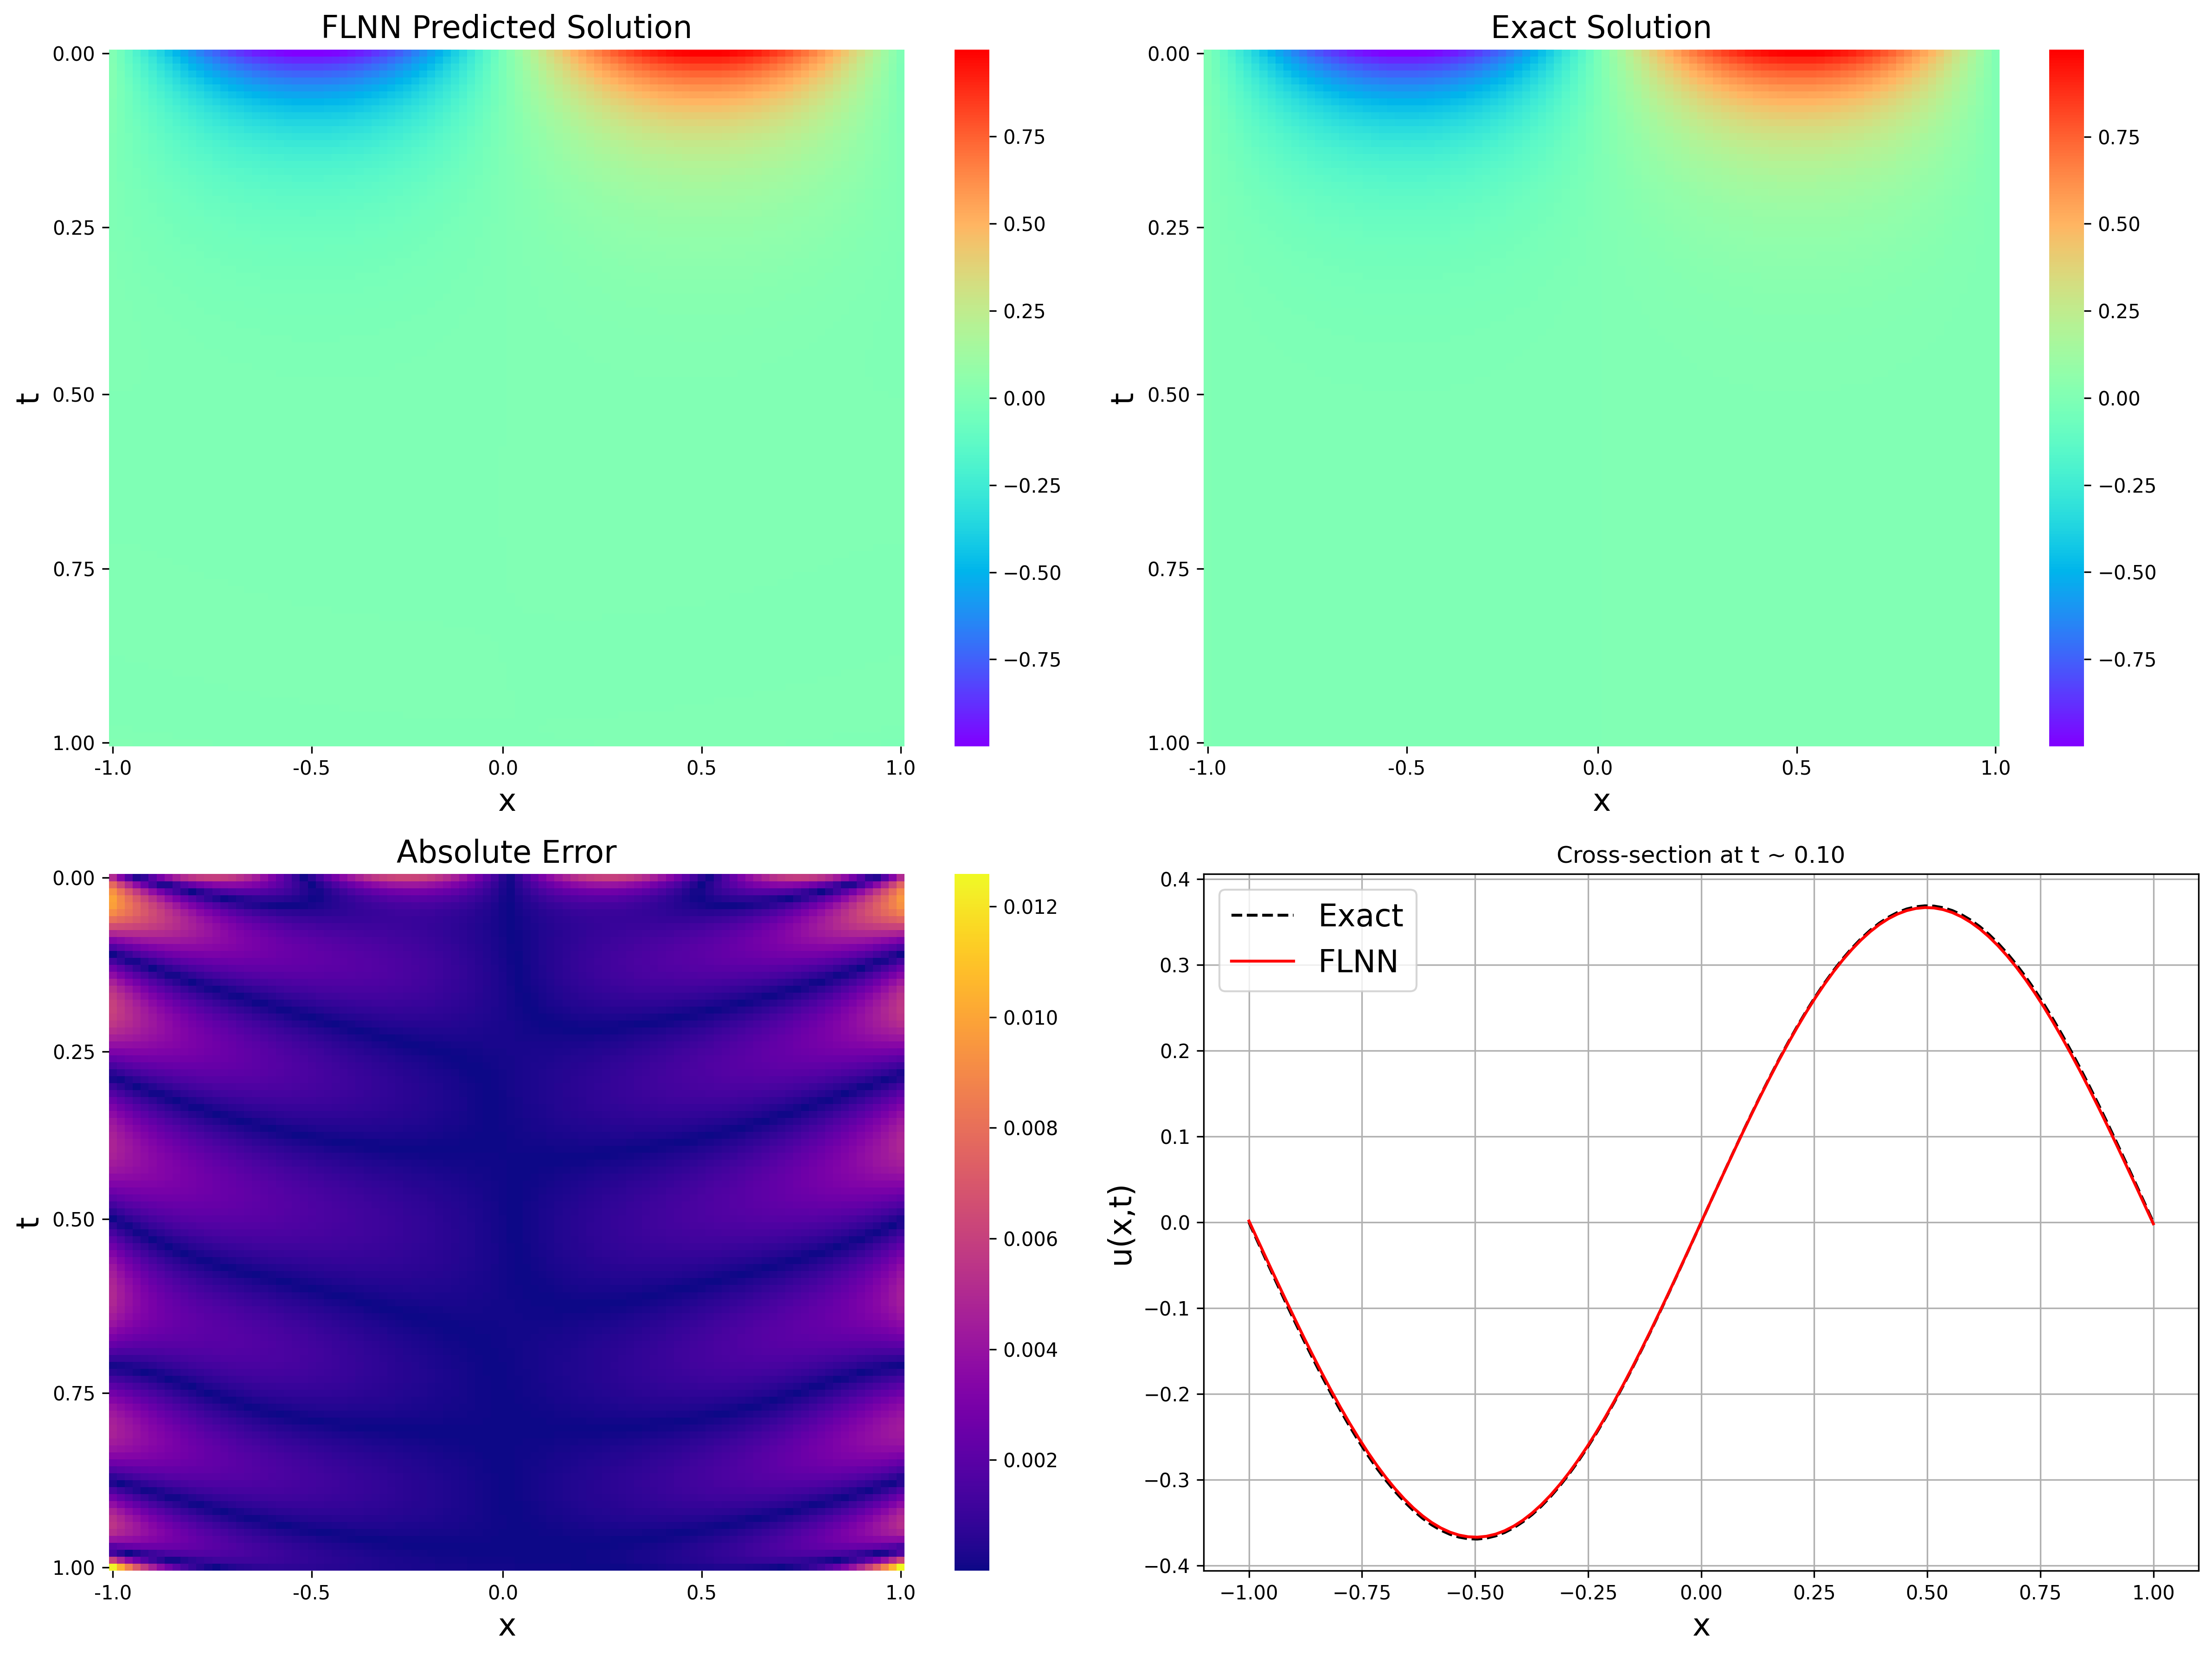

In [ ]:
# --- 4. Visualization ---
# Create a grid for plotting
x_test = np.linspace(-1, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

# Flatten for prediction
X_flat = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
T_flat = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    U_pred = model(X_flat, T_flat).numpy().reshape(100, 100)

# Exact Solution
U_exact = np.exp(-np.pi**2 * T) * np.sin(np.pi * X)

# Calculate Absolute Error
error = np.abs(U_pred - U_exact)

# Define desired tick values for x and t
desired_x_ticks = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
desired_t_ticks = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

# Find the closest indices in x_test and t_test for these desired values
x_tick_positions = [np.argmin(np.abs(x_test - val)) for val in desired_x_ticks]
t_tick_positions = [np.argmin(np.abs(t_test - val)) for val in desired_t_ticks]

x_tick_labels = [f'{val:.1f}' for val in desired_x_ticks]
t_tick_labels = [f'{val:.2f}' for val in desired_t_ticks]


# Plotting - 2 rows, 2 columns for 4 figures
fig, ax = plt.subplots(2, 2, figsize=(16, 12), dpi=300) # Adjusted figsize for 2x2 layout

# Figure 1: Heatmap FLNN Predicted Solution
sns.heatmap(U_pred, ax=ax[0, 0], cmap='rainbow', cbar=True, xticklabels=False, yticklabels=False)
ax[0, 0].set_title('FLNN Predicted Solution', fontsize=16)
ax[0, 0].set_xlabel('x', fontsize=16)
ax[0, 0].set_ylabel('t', fontsize=16)
# Center ticks on the cell, use calculated positions and set labels explicitly
ax[0, 0].set_xticks(np.array(x_tick_positions) + 0.5)
ax[0, 0].set_xticklabels(x_tick_labels)
ax[0, 0].set_yticks(np.array(t_tick_positions) + 0.5)
ax[0, 0].set_yticklabels(t_tick_labels)

# Figure 2: Heatmap Exact Solution
sns.heatmap(U_exact, ax=ax[0, 1], cmap='rainbow', cbar=True, xticklabels=False, yticklabels=False)
ax[0, 1].set_title('Exact Solution', fontsize=16)
ax[0, 1].set_xlabel('x', fontsize=16)
ax[0, 1].set_ylabel('t', fontsize=16)
ax[0, 1].set_xticks(np.array(x_tick_positions) + 0.5)
ax[0, 1].set_xticklabels(x_tick_labels)
ax[0, 1].set_yticks(np.array(t_tick_positions) + 0.5)
ax[0, 1].set_yticklabels(t_tick_labels)


# Figure 3: Heatmap Absolute Error
sns.heatmap(error, ax=ax[1, 0], cmap='plasma', cbar=True, xticklabels=False, yticklabels=False)
ax[1, 0].set_title('Absolute Error', fontsize=16)
ax[1, 0].set_xlabel('x', fontsize=16)
ax[1, 0].set_ylabel('t', fontsize=16)
ax[1, 0].set_xticks(np.array(x_tick_positions) + 0.5)
ax[1, 0].set_xticklabels(x_tick_labels)
ax[1, 0].set_yticks(np.array(t_tick_positions) + 0.5)
ax[1, 0].set_yticklabels(t_tick_labels)


# Figure 4: Cross-section at t=0.1
t_slice_idx = np.argmin(np.abs(t_test - 0.1)) # corresponds to t=0.1 approx
ax[1, 1].plot(x_test, U_exact[t_slice_idx, :], 'k--', label='Exact')
ax[1, 1].plot(x_test, U_pred[t_slice_idx, :], 'r-', label='FLNN')
ax[1, 1].set_title(f'Cross-section at t ~ {t_test[t_slice_idx]:.2f}')
ax[1, 1].legend(fontsize=16)
ax[1, 1].grid(True)
ax[1, 1].set_xlabel('x', fontsize=16)
ax[1, 1].set_ylabel('u(x,t)', fontsize=16)

plt.tight_layout()
plt.show()